In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

### Summarization MiddleWare

Automatically summarize conversation history when approaching token limits, preserving recent messages while compressing older context. Summarization is useful for the following:

- Long-running conversations that exceed context windows.
- Multi-turn dialogues with extensive history.
- Applications where preserving full conversation context matters.


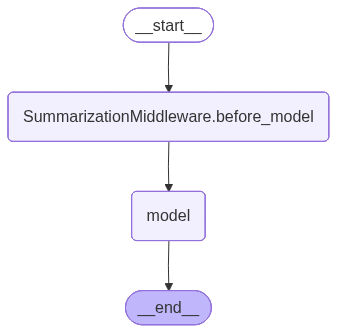

In [12]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain.messages import HumanMessage,SystemMessage


agent=create_agent(
    model="groq:qwen/qwen3-32b",
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="groq:qwen/qwen3-32b",
            trigger=("messages",10),
            keep=("messages",4)
        )
    ]
)
agent


In [13]:
## thread id
config={"configurable":{"thread_id":"test1"}}

In [21]:
# Alternative test data
questions = [
    "What is 2+2?",
    "What is 10*5?",
    "What is 100/4?",
    "What is 15-7?",
    "What is 3*3?",
    "What is 4*4?",
]

for q in questions:
    response=agent.invoke({"messages":[HumanMessage(content=q)]},config)
    print(f"Messages:{response["messages"][-1]}")
    print(f"Messages: {len(response['messages'])}")
    print(type(response))

Messages:content='<think>\nOkay, the user is asking "What is 2+2?" again. Let me check the history. They\'ve asked this before multiple times, and each time I answered with "2 plus 2 equals **4**. **Answer:** 4". Since they\'re repeating the same question, maybe they want to confirm if the answer is consistent or if I\'m paying attention. I should stick to the same format to maintain consistency. No need to add extra info unless they ask for more. Just the straightforward answer in bold again.\n</think>\n\n2 + 2 equals **4**.  \n\n**Answer:** 4' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 128, 'prompt_tokens': 342, 'total_tokens': 470, 'completion_time': 0.275083111, 'completion_tokens_details': None, 'prompt_time': 0.014414104, 'prompt_tokens_details': None, 'queue_time': 0.158833031, 'total_time': 0.289497215}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_2bfcc54d36', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None,

### Token Size

In [25]:

from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

@tool
def search_hotels(city: str) -> str:
    """Search hotels - returns long response to use more tokens."""
    return f"""Hotels in {city}:
    1. Grand Hotel - 5 star, $350/night, spa, pool, gym
    2. City Inn - 4 star, $180/night, business center
    3. Budget Stay - 3 star, $75/night, free wifi"""


agent=create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="groq:llama3-8b-8192",
            trigger=("tokens",550),
            keep=("tokens",200),
        ),
    ]
)

config = {"configurable": {"thread_id": "test-1"}}

# Token counter (approximate)
def count_tokens(messages):
    total_chars = sum(len(str(m.content)) for m in messages)
    return total_chars // 4  # 4 chars ≈ 1 token

In [26]:
# Run test
cities = ["Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Find hotels in {city}")]},
        config=config
    )
    
    tokens = count_tokens(response["messages"])
    print(f"{city}: ~{tokens} tokens, {len(response['messages'])} messages")
    print(f"{(response['messages'])}")

Paris: ~149 tokens, 4 messages
[HumanMessage(content='Find hotels in Paris', additional_kwargs={}, response_metadata={}, id='f19c8e42-6ad8-4698-b7dc-64a11d77e1b5'), AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user wants to find hotels in Paris. Let me check the available tools. There\'s a function called search_hotels that takes a city parameter. The description says it returns a long response to use more tokens. Hmm, maybe the response is detailed, which is good for the user. I need to call this function with the city set to Paris. Let me make sure the parameters are correct. The required parameter is city, and it\'s a string. So the arguments should be {"city": "Paris"}. I\'ll format the tool call accordingly.\n', 'tool_calls': [{'id': 'b4w5j798e', 'function': {'arguments': '{"city":"Paris"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 155, 'total_tokens': 294, 'completion

### Fraction

In [31]:
agent = create_agent(
    model="groq:llama-3.1-8b-instant",
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    system_prompt=(
        "You MUST use only the provided tools. "
        "Do NOT use web search, browser, or brave_search. "
        "If hotel data is needed, call search_hotels."
    ),
    middleware=[
        SummarizationMiddleware(
            model="groq:llama-3.1-8b-instant",
            trigger=("fraction", 0.005),
            keep=("fraction", 0.002),
        ),
    ],
)


### Human In the Loop MiddleWare
Pause agent execution for human approval, editing, or rejection of tool calls before they execute. Human-in-the-loop is useful for the following:

High-stakes operations requiring human approval (e.g. database writes, financial transactions).
Compliance workflows where human oversight is mandatory.
Long-running conversations where human feedback guides the agent.

In [32]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver

def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

In [33]:
agent=create_agent(
    model="groq:llama-3.1-8b-instant",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{
                    "allowed_decisions":["approve","edit","reject"]
                },
                "read_email_tool":False,

            }
        )
    ]
)

In [34]:
config = {"configurable": {"thread_id": "test-approve"}}
# Step 1: Request
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'")]},
    config=config
)

In [35]:
from langgraph.types import Command
# Step 2: Approve
if "__interrupt__" in result:
    print("⏸️ Paused! Approving...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {"type": "approve"}
                ]
            }
        ),
        config=config
    )
    
    print(f"✅ Result: {result['messages'][-1].content}")

⏸️ Paused! Approving...
✅ Result: Email sent to john@test.com with subject 'Hello'.


In [36]:

result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='e092973d-669c-45a6-b910-9afe20538a22'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '534qhey07', 'function': {'arguments': '{"body":"How are you?","recipient":"john@test.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 309, 'total_tokens': 341, 'completion_time': 0.028588123, 'completion_tokens_details': None, 'prompt_time': 0.021160885, 'prompt_tokens_details': None, 'queue_time': 0.045323396, 'total_time': 0.049749008}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3df5-7ff3-7e61-9993-997f952558d0-0', tool_calls=[{'name': 'send_email_tool', 'args': {'body

###  Reject

In [37]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="gpt-4o",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)

In [38]:
config = {"configurable": {"thread_id": "test-reject"}}
# Step 1: Request
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'")]},
    config=config)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [39]:
# Step 2: Reject
if "__interrupt__" in result:
    print("⏸️ Paused! Approving...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {"type": "reject"}
                ]
            }
        ),
        config=config
    )
    
    print(f"✅ Result: {result['messages'][-1].content}")

In [40]:

result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='e092973d-669c-45a6-b910-9afe20538a22'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '534qhey07', 'function': {'arguments': '{"body":"How are you?","recipient":"john@test.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 309, 'total_tokens': 341, 'completion_time': 0.028588123, 'completion_tokens_details': None, 'prompt_time': 0.021160885, 'prompt_tokens_details': None, 'queue_time': 0.045323396, 'total_time': 0.049749008}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3df5-7ff3-7e61-9993-997f952558d0-0', tool_calls=[{'name': 'send_email_tool', 'args': {'body

###  result

In [41]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver


def read_email_tool(email_id: str) -> str:
    """Mock function to read an email by its ID."""
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient: str, subject: str, body: str) -> str:
    """Mock function to send an email."""
    return f"Email sent to {recipient} with subject '{subject}'"

agent = create_agent(
    model="gpt-4o",
    tools=[read_email_tool,send_email_tool],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool": {
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email_tool": False,
            }
        ),
    ],
)

In [42]:
config = {"configurable": {"thread_id": "test-edit"}}

# Step 1: Request (with wrong info)
result = agent.invoke(
    {"messages": [HumanMessage(content="Send email to wrong@email.com with subject 'Test' and body 'Hello'")]},
    config=config
)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [43]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='e092973d-669c-45a6-b910-9afe20538a22'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '534qhey07', 'function': {'arguments': '{"body":"How are you?","recipient":"john@test.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 309, 'total_tokens': 341, 'completion_time': 0.028588123, 'completion_tokens_details': None, 'prompt_time': 0.021160885, 'prompt_tokens_details': None, 'queue_time': 0.045323396, 'total_time': 0.049749008}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3df5-7ff3-7e61-9993-997f952558d0-0', tool_calls=[{'name': 'send_email_tool', 'args': {'body

In [44]:
# Step 2: Edit and approve
if "__interrupt__" in result:
    print("⏸️ Paused! Editing...")
    
    result = agent.invoke(
        Command(
            resume={
                "decisions": [
                    {
                        "type": "edit",
                        "edited_action": {
                            "name": "send_email_tool",      # Tool name
                            "args": {                   # New arguments
                                "recipient": "correct@email.com",
                                "subject": "Corrected Subject",
                                "body": "This was edited by human before sending"
                            }
                        }
                    }
                ]
            }
        ),
        config=config
    )
    
    print(f"✏️ Result: {result['messages'][-1].content}")

In [45]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'Hello' and body 'How are you?'", additional_kwargs={}, response_metadata={}, id='e092973d-669c-45a6-b910-9afe20538a22'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '534qhey07', 'function': {'arguments': '{"body":"How are you?","recipient":"john@test.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 309, 'total_tokens': 341, 'completion_time': 0.028588123, 'completion_tokens_details': None, 'prompt_time': 0.021160885, 'prompt_tokens_details': None, 'queue_time': 0.045323396, 'total_time': 0.049749008}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3df5-7ff3-7e61-9993-997f952558d0-0', tool_calls=[{'name': 'send_email_tool', 'args': {'body